# Experiment 2

## Feature Normalization for Model Performance

Now that we know that XGB performs better than *most* the out of the box models that sklearn has to offer us we can see how normalizing the features affects XGB's accuracy. In this notebook I will test several different regularization methods, including:
- Scaling
- Normalizing (scaling vectors to unit norm)
- PCA for dimensionality reduction/visualizing decision boundaries of the model

In [1]:
from scipy.io import arff
import pandas
from sklearn import svm, naive_bayes, ensemble, neural_network, metrics
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, decomposition, manifold
import numpy as np
from bayes_opt import BayesianOptimization
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
data, meta = arff.loadarff('emobase2010.old.arff')

In [4]:
df = pandas.DataFrame.from_records(data)

In [5]:
df.columns = data.dtype.names

In [6]:
# remove neutral, unknown and other classes
a = df['class']!=b'NEU'
b = df['class']!=b'UNK'
c = df['class']!=b'OTH'
df = df.loc[a&b&c]

In [7]:
adata = df.as_matrix()

In [8]:
features, labels = np.split(adata, [-1], axis=1)
labels = [s for s in labels]

In [9]:
print(np.shape(labels))
le = LabelEncoder()
labels = [s[0] for s in labels]
le.fit(labels)
labels = le.transform(labels)
print(labels)

(2743, 1)
[0 3 0 ..., 1 2 1]


And now that we know the best performing hyperparameters from the last experiment...

In [10]:
params = {'subsample': 0.86358306525373618,
          'colsample_bytree': 0.33658558928849269,
          'max_depth': 9.4543347834429881,
          'min_child_weight': 6.0659314521001315,
          'gamma': 2.1000619104831797}

params['min_child_weight'] = int(params['min_child_weight'])
params['colsample_bytree'] = max(min(params['colsample_bytree'], 1), 0)
params['max_depth'] = int(params['max_depth'])
params['subsample'] = max(min(params['subsample'], 1), 0)
params['gamma'] = max(params['gamma'], 0)

Now let's begin the normalization experiments!

First, let's see a baseline with the default parameters.

In [12]:
wclf = xgb.XGBClassifier()
predicted = cross_val_predict(wclf, features, labels)
metrics.accuracy_score(labels, predicted)

0.30441122858184472

Ok, now let's see if we can beat it.

## Scaling

I will first try scaling the data to most closely match the normal distribution (i.e. zero mean and unit variance)

In [9]:
scaled_features = preprocessing.scale(features)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [10]:
wclf = xgb.XGBClassifier()
predicted = cross_val_predict(wclf, scaled_features, labels)
metrics.accuracy_score(labels, predicted)

0.30586948596427271

Just as a refresher we got 0.304 before, so it looks like the feature scaling actually improved our baseline a tiny amount. Let's try and optimize for this new normalized dataset now.

In [14]:
def xgbeval(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    wclf = xgb.XGBClassifier(**params)
    
    predicted = cross_val_predict(wclf, scaled_features, labels)
    
    return metrics.accuracy_score(labels, predicted)

In [15]:
num_rounds = 3000
random_state = 2017
num_iter = 10
init_points = 5
params = {}

xgbBO = BayesianOptimization(xgbeval, {'min_child_weight': (1, 20),
                                                'colsample_bytree': (0.1, 1),
                                                'max_depth': (5, 15),
                                                'subsample': (0.5, 1),
                                                'gamma': (0, 10)
                                                })
xgbBO.maximize(init_points=init_points, n_iter=num_iter)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
    1 | 07m55s |    0.31243 |             0.6274 |    8.4727 |     10.0078 |            11.8310 |      0.7959 | 
    2 | 05m11s |    0.30332 |             0.2366 |    3.7201 |     13.4627 |             7.1025 |      0.7952 | 
    3 | 09m46s |    0.29457 |             0.8649 |    1.1344 |     11.8845 |             3.0131 |      0.5217 | 
    4 | 07m27s |    0.30077 |             0.5876 |    8.8428 |     13.8298 |            16.9543 |      0.9659 | 
    5 | 07m17s |    0.30550 |             0.9154 |    0.8203 |      7.0333 |            18.8690 |      0.6436 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma 

In [16]:
print('Final Results')
print('XGBOOST: %f' % xgbBO.res['max']['max_val'])
print('Best Params: {}'.format(xgbBO.res['max']['max_params']))

Final Results
XGBOOST: 0.313525
Best Params: {'colsample_bytree': 0.10000000000000001, 'max_depth': 5.0, 'gamma': 5.0116442318155811e-10, 'subsample': 1.0, 'min_child_weight': 11.663919262075398}


We can see that there's a similar small improvement with the more optimized model (0.313 vs 0.311). Let's see what normalization gets us.

## Normalization

For normalization the goal is to scale each feature vector to it's unit norm.

In [11]:
norm_features = preprocessing.normalize(features)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [13]:
wclf = xgb.XGBClassifier(**params)
predicted = cross_val_predict(wclf, norm_features, labels)
metrics.accuracy_score(labels, predicted)

0.2872767043383157

Hmm, we some to have done a little worse this time around. Let's move on to the optimization for this new normalized featureset.

In [15]:
def xgbeval(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    wclf = xgb.XGBClassifier(**params)
    
    predicted = cross_val_predict(wclf, norm_features, labels)
    
    return metrics.accuracy_score(labels, predicted)

In [ ]:
num_rounds = 3000
random_state = 2017
num_iter = 10
init_points = 5
params = {}

xgbBO = BayesianOptimization(xgbeval, {'min_child_weight': (1, 20),
                                                'colsample_bytree': (0.1, 1),
                                                'max_depth': (5, 15),
                                                'subsample': (0.5, 1),
                                                'gamma': (0, 10)
                                                })
xgbBO.maximize(init_points=init_points, n_iter=num_iter)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
    1 | 120m44s |    0.28254 |             0.8081 |    8.7588 |      7.4573 |            15.7252 |      0.8583 | 
    2 | 09m48s |    0.29275 |             0.8348 |    5.1320 |      7.3004 |            10.6826 |      0.6291 | 
    3 | 08m28s |    0.28983 |             0.5820 |    6.1729 |     14.2192 |             9.0152 |      0.5808 | 
    4 | 03m36s |    0.28071 |             0.2136 |    9.4464 |      8.4718 |             4.3571 |      0.6348 | 
    5 | 52m40s |    0.29639 |             0.7064 |    4.0460 |      9.9645 |             7.8131 |      0.7466 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma

## PCA

### Normalization
PCA will allow us to get rid of linear dependence within our feature matrix.

### Visualiziation
We can also use PCA to visualize the decision boundary of our XGB classifier to get some idea of how it's working.

In [35]:
pca = decomposition.PCA(0.95)

In [36]:
proj_features = pca.fit_transform(features)

In [37]:
print(proj_features.shape)
print(features.shape)
print(pca.explained_variance_ratio_)

(2743, 2)
(2743, 1582)
[ 0.7874917   0.17960625]


Interestingly we can account for 95% of the variance with only the first two features. Let's see how our classifier performs on this (note: I'm expecting it to be much worse).

In [38]:
wclf = xgb.XGBClassifier()
predicted = cross_val_predict(wclf, proj_features, labels)
metrics.accuracy_score(labels, predicted)

0.2012395187750638

Yeah that makes sense, but that's alright. We can try and optimize this first and then we'll visualize the decision boundary.

In [43]:
def xgbeval(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 1e-5)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    wclf = xgb.XGBClassifier(**params)
    
    predicted = cross_val_predict(wclf, proj_features, labels)
    
    return metrics.accuracy_score(labels, predicted)

In [46]:
num_rounds = 3000
random_state = 2017
num_iter = 10
init_points = 5
params = {}

xgbBO = BayesianOptimization(xgbeval, {'min_child_weight': (1, 20),
                                                'colsample_bytree': (0.5, 1),
                                                'max_depth': (5, 15),
                                                'subsample': (0.5, 1),
                                                'gamma': (0, 10)
                                                })
xgbBO.maximize(init_points=init_points, n_iter=num_iter)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
    1 | 00m01s |    0.20306 |             0.5470 |    4.3902 |     13.8832 |             7.4068 |      0.5659 | 
    2 | 00m01s |    0.18192 |             0.8169 |    0.1906 |      9.0157 |            11.5659 |      0.7866 | 
    3 | 00m01s |    0.20598 |             0.9357 |    8.4383 |      8.5284 |             2.1193 |      0.9619 | 
    4 | 00m01s |    0.20707 |             0.6454 |    7.1961 |     10.1518 |            12.6819 |      0.9403 | 
    5 | 00m00s |    0.20452 |             0.7434 |    1.7954 |      5.0933 |            12.0038 |      0.8288 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'funcalls': 50, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.19538805e-05]), 'warnflag': 2, 'nit': 5}
  " state: %s" % convergence_dict)


   11 | 00m07s |    0.19650 |             0.9081 |    0.1400 |      5.0449 |            19.9875 |      0.7681 | 
   12 | 00m07s |    0.20525 |             0.9933 |    9.6883 |     14.9233 |             8.7790 |      0.7909 | 
   13 | 00m08s |    0.20890 |             1.0000 |    6.0475 |      5.0000 |            16.5774 |      0.9898 | 
   14 | 00m09s |    0.19978 |             0.9447 |    9.9007 |      5.0239 |             1.0816 |      0.7660 | 
   15 | 00m11s |    0.20561 |             0.8764 |    5.3203 |      5.1228 |             6.6912 |      0.9996 | 


In [47]:
print('Final Results')
print('XGBOOST: %f' % xgbBO.res['max']['max_val'])
print('Best Params: {}'.format(xgbBO.res['max']['max_params']))

Final Results
XGBOOST: 0.208895
Best Params: {'colsample_bytree': 0.99999998805632262, 'max_depth': 5.0, 'gamma': 6.0474648508329105, 'subsample': 0.98978259639861343, 'min_child_weight': 16.577418412655497}


Not an amazing improvement, but let's start building this visualization.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(proj_features, labels, 
                                                    test_size=0.33, random_state=42)

In [60]:
params = xgbBO.res['max']['max_params']
params['min_child_weight'] = int(params['min_child_weight'])
params['colsample_bytree'] = max(min(params['colsample_bytree'], 1), 1e-5)
params['max_depth'] = int(params['max_depth'])
params['subsample'] = max(min(params['subsample'], 1), 0)
params['gamma'] = max(params['gamma'], 0)

wclf = xgb.XGBClassifier(**params)
wclf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.99999998805632262, gamma=6.0474648508329105,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=16, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.98978259639861343)

In [61]:
# Step size for mesh
h = .02

x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

This is going to take a while, just a warning.

In [62]:
Z = wclf.predict(np.c_[xx.ravel(), yy.ravel()])

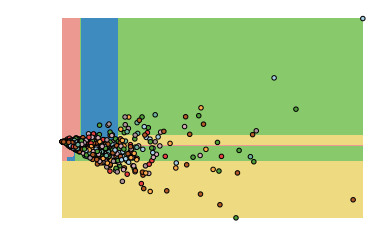

In [75]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis('off')

# Plot also the training points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired)

Well at least it looks pretty cool. We can see we have some outliers though, so further experiments can be done on trying to strip those. It doesn't look like there are clear clusters as well, something that tSNE is particularly good at getting. Let's try visualizing the tSNE projection of the data to see if we can't find some clusters.

## tSNE

In [77]:
tsne = manifold.TSNE(n_components=2, random_state=2017)
tsne_features = tsne.fit_transform(features)

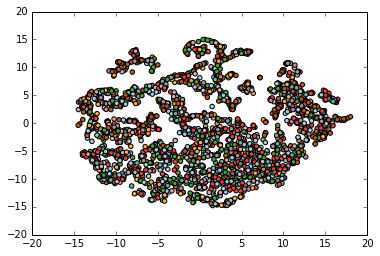

In [78]:
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap=plt.cm.Paired)

So it definitely doesn't look like there's a huge amount of obvious clustering in the data, let's see the decision boundaries.

In [79]:
X_train, X_test, y_train, y_test = train_test_split(tsne_features, labels, 
                                                    test_size=0.33, random_state=42)

In [80]:
def xgbeval(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 1e-5)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    wclf = xgb.XGBClassifier(**params)
    
    predicted = cross_val_predict(wclf, tsne_features, labels)
    
    return metrics.accuracy_score(labels, predicted)

In [81]:
num_rounds = 3000
random_state = 2017
num_iter = 10
init_points = 5
params = {}

xgbBO = BayesianOptimization(xgbeval, {'min_child_weight': (1, 20),
                                                'colsample_bytree': (0.5, 1),
                                                'max_depth': (5, 15),
                                                'subsample': (0.5, 1),
                                                'gamma': (0, 10)
                                                })
xgbBO.maximize(init_points=init_points, n_iter=num_iter)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
    1 | 00m02s |    0.18009 |             0.7095 |    0.4907 |     11.8051 |             2.1600 |      0.7888 | 
    2 | 00m00s |    0.22712 |             0.8579 |    8.1241 |      6.8005 |            10.0896 |      0.9512 | 
    3 | 00m01s |    0.21436 |             0.5960 |    2.9504 |     13.4598 |            14.4807 |      0.5219 | 
    4 | 00m01s |    0.22749 |             0.5783 |    5.9871 |     12.1258 |             6.9647 |      0.5794 | 
    5 | 00m01s |    0.21035 |             0.8654 |    3.6965 |     14.2123 |             8.2463 |      0.9804 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'funcalls': 54, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.21633706e-05]), 'warnflag': 2, 'nit': 5}
  " state: %s" % convergence_dict)


    7 | 00m09s |    0.22530 |             0.9252 |    9.9369 |     14.8183 |             1.0912 |      0.7499 | 
    8 | 00m10s |    0.22567 |             0.5000 |   10.0000 |      5.4215 |            20.0000 |      0.5000 | 


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'funcalls': 50, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.73884639e-05]), 'warnflag': 2, 'nit': 5}
  " state: %s" % convergence_dict)


    9 | 00m10s |    0.22093 |             0.7242 |    9.9681 |      5.2017 |             1.4119 |      0.5636 | 
   10 | 00m11s |    0.22384 |             0.5044 |    9.8589 |     14.8432 |             9.7469 |      0.5262 | 
   11 | 00m08s |    0.21327 |             0.9882 |    0.0230 |      5.2787 |            19.9111 |      0.6309 | 
   12 | 00m09s |    0.22166 |             1.0000 |    9.8764 |      9.8994 |             6.2860 |      0.5000 | 
   13 | 00m12s |    0.22275 |             0.5003 |    4.4859 |      5.1896 |            14.5084 |      0.5491 | 
   14 | 00m16s |    0.22712 |             0.5030 |    5.3157 |     10.5157 |            19.7892 |      0.9544 | 


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'funcalls': 46, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.21947489e-05]), 'warnflag': 2, 'nit': 3}
  " state: %s" % convergence_dict)


   15 | 00m15s |    0.21983 |             0.5000 |   10.0000 |     10.8754 |            14.4036 |      1.0000 | 


In [82]:
params = xgbBO.res['max']['max_params']
params['min_child_weight'] = int(params['min_child_weight'])
params['colsample_bytree'] = max(min(params['colsample_bytree'], 1), 1e-5)
params['max_depth'] = int(params['max_depth'])
params['subsample'] = max(min(params['subsample'], 1), 0)
params['gamma'] = max(params['gamma'], 0)

wclf = xgb.XGBClassifier(**params)
wclf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.57826035139669052, gamma=5.9870819249823048,
       learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=6, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.57942925682328927)

In [83]:
# Step size for mesh
h = .02

x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [84]:
Z = wclf.predict(np.c_[xx.ravel(), yy.ravel()])

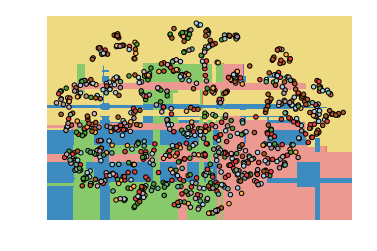

In [85]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis('off')

# Plot also the training points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired)

This is at least more interesting than the PCA analysis, as well as getting better performance on the actual classification task. I suppose this gives us some insight into why this is such a difficult task.

## Conclusions

We found featutre scaling to be slightly more effective, and normalization less effective than no normalization for classification accuracy. Further, we saw that the data itself has very little discernable structure w/r/t clustering, which may account for the high level of difficulty of this classification task.

Scaling | Scaling w/ BO | Normalization | Normalization w/ BO | PCA | PCA w/ BO | tSNE w/ BO
--- | --- | --- | --- | --- | --- | ---
0.306 | 0.314 | 0.287 | 0.296 | 0.201 | 0.209 | 0.227